In [9]:
import pandas as pd

cbic = pd.read_csv('MRI_CBIC_participants.csv', index_col=0)
cbic = cbic.drop_duplicates()
cbic['site'] = 'cbic'
rubic = pd.read_csv('MRI_RU_participants.csv', index_col=0)
rubic = rubic.drop_duplicates()
rubic['site'] = 'rubic'
full = pd.concat([cbic, rubic])
full = full.drop_duplicates()
full.to_csv('temp.csv')

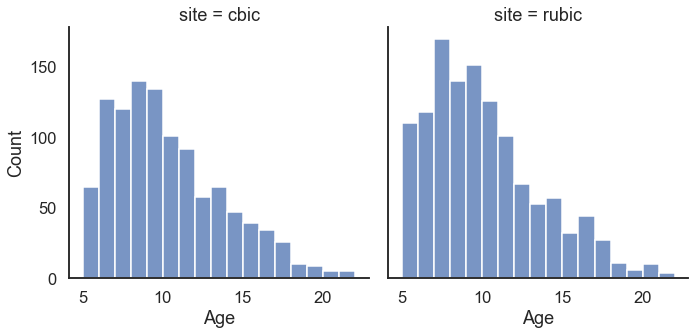

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk', style='white')

sns.displot(data=full, x='Age', col='site', binwidth=1)
plt.tight_layout()
#plt.savefig('ages_2sites.png')

(2111, 8)

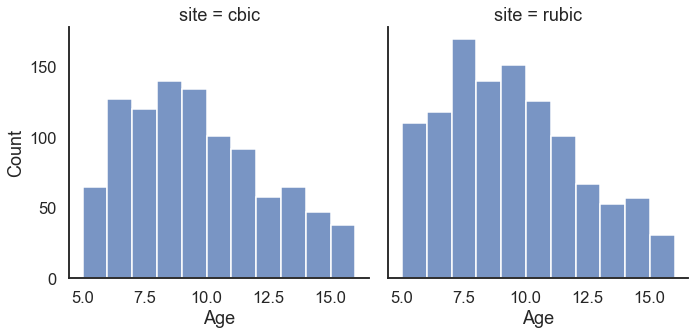

In [12]:
full_10u = full[full['Age']<=16]
full_10u.to_csv('unique_px_list_15u.csv')
sns.displot(data=full_10u, x='Age',col='site',binwidth=1)
plt.tight_layout()
#plt.savefig('ages_2sites_15under.svg')
full_10u.shape

## Make text files to enable downloading and processing subject data

In [4]:
# remove kids with the abcd sequence (can't unwarp)
full_10u = full_10u[full_10u['Bold.Sequence'] != 'abcd']
full_10u = full_10u.sort_values(by=['site','participant_id'])
print(full_10u.head())

listlimit=75
nchunks = int(full_10u.shape[0] // listlimit) +1 
start = 0

for a in range(0,nchunks):
    dl_file = open('./for_proc/download_list{0}.txt'.format(str(a).zfill(2)), 'w')
    sublist_file = open('./for_proc/sublist{0}.txt'.format(str(a).zfill(2)), 'w')
    end = start + listlimit
    if end > len(full_10u):
        end = len(full_10u)
    t = full_10u.iloc[start:end,:]
    for i in t.index:
        if 'cbic' in full_10u.loc[i,'site']:
            site = 'CBIC'
        else:
            site = 'RU'
        dl_file.write('https://fcp-indi.s3.amazonaws.com/data/Archives/HBN/MRI/Site-{0}/sub-{1}.tar.gz\n'.format(site,i))
        sublist_file.write('sub-{0}\n'.format(i))
    start = end

               release_number Bold.Sequence  Sex        Age  EHQ_Total  \
participant_id                                                           
NDARAA504CRN               R8          cmrr    1   9.165297      73.34   
NDARAA947ZG5               R7          cmrr    0  13.627880      80.00   
NDARAB348EWR               R6          cmrr    0   5.805384      80.00   
NDARAB458VK9               R6          cmrr    0  12.836185      80.00   
NDARAB514MAJ               R7          cmrr    0   5.055213      30.00   

               Commercial_Use Full_Pheno  site  
participant_id                                  
NDARAA504CRN              Yes        Yes  cbic  
NDARAA947ZG5              Yes        Yes  cbic  
NDARAB348EWR              Yes        Yes  cbic  
NDARAB458VK9              Yes        Yes  cbic  
NDARAB514MAJ              Yes        Yes  cbic  


## organize phenotypic data

In [14]:
import pandas as pd
import numpy as np

# add CBCL T-scores to dataframe with selected MRI data
cbcl6u = pd.read_csv('/Users/catcamacho/Box/CCP/HBN_study/phenotypic_data/9994_CBCL_20210322.csv', 
                     index_col='EID', header=0, skiprows=[1],
                     usecols=['EID','CBCL_AB','CBCL_AD','CBCL_AP','CBCL_Ext','CBCL_Int',
                              'CBCL_SC','CBCL_SP','CBCL_Total','CBCL_WD'])
cbcl5b = pd.read_csv('/Users/catcamacho/Box/CCP/HBN_study/phenotypic_data/9994_CBCL_Pre_20210322.csv',
                     index_col='EID', header=0,skiprows=[1], 
                     usecols=['EID','CBCL_Pre_AB','CBCL_Pre_AD','CBCL_Pre_AP','CBCL_Pre_Ext',
                              'CBCL_Pre_Int','CBCL_Pre_SC','CBCL_Pre_SP','CBCL_Pre_Total','CBCL_Pre_WD'])
cbcl5b = cbcl5b.sort_index(axis=1)
cbcl5b.columns=['CBCL_AB','CBCL_AD','CBCL_AP','CBCL_Ext','CBCL_Int',
                'CBCL_SC','CBCL_SP','CBCL_Total','CBCL_WD']
cbcl = pd.concat([cbcl6u,cbcl5b])

# add ESWAN data
eswan = pd.read_csv('/Users/catcamacho/Box/CCP/HBN_study/phenotypic_data/9994_ESWAN_20210322.csv', 
                     index_col='EID', header=0, skiprows=[1])
eswan = eswan.drop(['Anonymized ID','Subject Type','Visit','Days since enrollment','START_DATE',
                    'Study','Site','Days_Baseline','Year','Season'], axis=1)
eswan['MDD_mean'] = eswan[['MDD_1A','MDD_1B','MDD_2A','MDD_2B','MDD_3A','MDD_3B','MDD_4','MDD_5','MDD_6',
                           'MDD_7','MDD_8A','MDD_8B','MDD_9']].mean(axis=1, skipna=True)
eswan['SocAnx_mean'] = eswan[['SocAnx_01','SocAnx_02','SocAnx_03','SocAnx_04A','SocAnx_04B',
                              'SocAnx_05']].mean(axis=1, skipna=True)
eswan['Panic_mean'] =eswan[['Panic_A01','Panic_A02','Panic_A03','Panic_B01','Panic_B02','Panic_B03',
                            'Panic_B04','Panic_B05','Panic_B06','Panic_B07','Panic_B08','Panic_B09',
                            'Panic_B10','Panic_B11','Panic_B12','Panic_B13']].mean(axis=1,skipna=True)
eswan['DMDD_mean'] = eswan[[a for a in eswan.columns if 'DMDD_' in a]].mean(axis=1, skipna=True)
dmddcols = []
for x in range(1,11):
    eswan['DMDD{0}max'.format(x)] = eswan[['DMDD_{0}A'.format(x),'DMDD_{0}B'.format(x),'DMDD_{0}C'.format(x)]].max(axis=1)
    dmddcols.append('DMDD{0}max'.format(x))
    eswan['DMDD{0}mean'.format(x)] = eswan[['DMDD_{0}A'.format(x),'DMDD_{0}B'.format(x),'DMDD_{0}C'.format(x)]].mean(axis=1)
    dmddcols.append('DMDD{0}mean'.format(x))
eswan['DMDD_maxmean'] = eswan[dmddcols].mean(axis=1, skipna=True)
    
panas = pd.read_csv('/Users/catcamacho/Box/CCP/HBN_study/phenotypic_data/9994_PANAS_20210322.csv',
                    index_col='EID',header=0,skiprows=[1],
                    usecols=['EID','PANAS_PositiveAffect','PANAS_NegativeAffect'])

scaredsr = pd.read_csv('/Users/catcamacho/Box/CCP/HBN_study/phenotypic_data/9994_SCARED_SR_20210322.csv',
                    index_col='EID',header=0,skiprows=[1],
                    usecols=['EID','SCARED_SR_GD','SCARED_SR_PN','SCARED_SR_SC','SCARED_SR_SH','SCARED_SR_SP','SCARED_SR_Total'])
scaredpr = pd.read_csv('/Users/catcamacho/Box/CCP/HBN_study/phenotypic_data/9994_SCARED_P_20210322.csv',
                    index_col='EID',header=0,skiprows=[1],
                    usecols=['EID','SCARED_P_GD','SCARED_P_PN','SCARED_P_SC','SCARED_P_SH','SCARED_P_SP','SCARED_P_Total'])

mfqpr = pd.read_csv('/Users/catcamacho/Box/CCP/HBN_study/phenotypic_data/9994_MFQ_P_20210322.csv',
                    index_col='EID',header=0,skiprows=[1],usecols=['EID','MFQ_P_Total'])
mfqsr = pd.read_csv('/Users/catcamacho/Box/CCP/HBN_study/phenotypic_data/9994_MFQ_SR_20210322.csv',
                    index_col='EID',header=0,skiprows=[1],usecols=['EID','MFQ_SR_Total'])

dx = pd.read_csv('/Users/catcamacho/Box/CCP/HBN_study/phenotypic_data/9994_ConsensusDx_20210322.csv',
                    index_col='EID',header=0,skiprows=[1],usecols=['EID','DX_01_Cat','DX_02_Cat','DX_02_Cat','DX_04_Cat','DX_05_Cat',
                                                                   'DX_06_Cat','DX_07_Cat','DX_08_Cat','DX_09_Cat','DX_10_Cat',
                                                                   'DX_01_Sub','DX_02_Sub','DX_02_Sub','DX_04_Sub','DX_05_Sub',
                                                                   'DX_06_Sub','DX_07_Sub','DX_08_Sub','DX_09_Sub','DX_10_Sub'])
dx['ID'] = dx.index
dx = dx.drop_duplicates(subset='ID')
dx = dx.drop('ID', axis=1)

# summarize diagnosis information
dx['dx_text'] = dx[['DX_01_Cat','DX_02_Cat','DX_02_Cat','DX_04_Cat','DX_05_Cat','DX_06_Cat','DX_07_Cat','DX_08_Cat',
                   'DX_09_Cat','DX_10_Cat','DX_01_Sub','DX_02_Sub','DX_02_Sub','DX_04_Sub','DX_05_Sub',
                    'DX_06_Sub','DX_07_Sub','DX_08_Sub','DX_09_Sub','DX_10_Sub']].apply(lambda row: ', '.join(row.values.astype(str)), axis=1)
dx['dx_dep'] = dx['dx_text'].map(lambda x: 1 if 'Depressive' in x else 0)
dx['dx_anx'] = dx['dx_text'].map(lambda x: 1 if 'Anxiety' in x else 0)
dx['dx_nd_adhd'] = dx['dx_text'].map(lambda x: 1 if 'Attention-Deficit' in x else 0)
dx['dx_nd_asd'] = dx['dx_text'].map(lambda x: 1 if 'Autism' in x else 0)
dx['dx_nd_int'] = dx['dx_text'].map(lambda x: 1 if 'Intellectual' in x else 0)
dx['dx_nd_learn'] = dx['dx_text'].map(lambda x: 1 if 'Learning' in x else 0)
dx['dx_nd_com'] = dx['dx_text'].map(lambda x: 1 if 'Communication' in x else 0)
dx['dx_nd_mot'] = dx['dx_text'].map(lambda x: 1 if 'Motor' in x else 0)
dx['dx_nd_oth'] = dx['dx_text'].map(lambda x: 1 if 'Other Neurodevelop' in x else 0)
dx['dx_sub'] = dx['dx_text'].map(lambda x: 1 if 'Substance' in x else 0)
dx['dx_disr'] = dx['dx_text'].map(lambda x: 1 if 'Disruptive' in x else 0)
dx['dx_trauma'] = dx['dx_text'].map(lambda x: 1 if 'Trauma' in x else 0)
dx['dx_psy'] = dx['dx_text'].map(lambda x: 1 if 'Schizophrenia' in x else 0)
dx['dx_ocd'] = dx['dx_text'].map(lambda x: 1 if 'Obsessive' in x else 0)
dx['dx_elim'] = dx['dx_text'].map(lambda x: 1 if 'Elimination' in x else 0)
dx['dx_bip'] = dx['dx_text'].map(lambda x: 1 if 'Bipolar' in x else 0)
dx['dx_eat'] = dx['dx_text'].map(lambda x: 1 if 'Eating' in x else 0)
dx['INCOMPLETE'] = dx['dx_text'].map(lambda x: 1 if 'Incomplete' in x else 0)
dx[dx['INCOMPLETE']==1]=np.nan
dx=dx[['dx_text', 'dx_dep','dx_anx', 'dx_nd_adhd','dx_nd_asd','dx_nd_int','dx_nd_learn', 'dx_nd_com',
       'dx_nd_mot','dx_nd_oth','dx_sub', 'dx_disr', 'dx_trauma', 'dx_psy','dx_ocd', 'dx_elim', 'dx_bip','dx_eat']]


# put them all together
q_data = cbcl.join([eswan,panas,mfqsr,mfqpr,scaredsr,scaredpr,dx],how='outer')
q_data = q_data.drop_duplicates()
q_data.index.name='subject_id'
#q_data.to_csv('/Users/catcamacho/Box/CCP/HBN_study/phenotypic_data/full_sample_internqs_20210527.csv')

In [15]:
mri_sample = full_10u.join(q_data, how='left')
mri_sample
mri_sample.to_csv('/Users/catcamacho/Box/CCP/HBN_study/phenotypic_data/mri_data_qdata_20210527.csv')
mri_sample.describe().to_csv('/Users/catcamacho/Box/CCP/HBN_study/phenotypic_data/mri_data_descriptions_20210527.csv')

In [69]:
for a in mri_sample.columns:
    print(a)

release_number
Bold.Sequence
Sex
Age
EHQ_Total
Commercial_Use
Full_Pheno
site
CBCL_AD
CBCL_WD
CBCL_SC
CBCL_SP
CBCL_AP
CBCL_AB
CBCL_Int
CBCL_Ext
CBCL_Total
MDD_1A
MDD_1B
MDD_2A
MDD_2B
MDD_3A
MDD_3B
MDD_4
MDD_5
MDD_6
MDD_7
MDD_8A
MDD_8B
MDD_9
SocAnx_01
SocAnx_02
SocAnx_03
SocAnx_04A
SocAnx_04B
SocAnx_05
DMDD_1A
DMDD_1B
DMDD_1C
DMDD_2A
DMDD_2B
DMDD_2C
DMDD_3A
DMDD_3B
DMDD_3C
DMDD_4A
DMDD_4B
DMDD_4C
DMDD_5A
DMDD_5B
DMDD_5C
DMDD_6A
DMDD_6B
DMDD_6C
DMDD_7A
DMDD_7B
DMDD_7C
DMDD_8A
DMDD_8B
DMDD_8C
DMDD_9A
DMDD_9B
DMDD_9C
DMDD_10A
DMDD_10B
DMDD_10C
Panic_A01
Panic_A02
Panic_A03
Panic_A01A
Panic_A01B
Panic_A02A
Panic_A02B
Panic_A03A
Panic_A03B
Panic_B01
Panic_B02
Panic_B03
Panic_B04
Panic_B05
Panic_B06
Panic_B07
Panic_B08
Panic_B09
Panic_B10
Panic_B11
Panic_B12
Panic_B13
MDD_mean
SocAnx_mean
Panic_mean
DMDD_mean
DMDD1max
DMDD1mean
DMDD2max
DMDD2mean
DMDD3max
DMDD3mean
DMDD4max
DMDD4mean
DMDD5max
DMDD5mean
DMDD6max
DMDD6mean
DMDD7max
DMDD7mean
DMDD8max
DMDD8mean
DMDD9max
DMDD9mean
DMDD10max
DMDD1

In [111]:
sns.set(context='paper', style='white')
mri_sample['depanx_dx'] = np.nan
mri_sample['depanx_dx'][(mri_sample['dx_dep']==1) | (mri_sample['dx_anx']==1)]=1
mri_sample['depanx_dx'][(mri_sample['dx_dep']==0) & (mri_sample['dx_anx']==0)]=0

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


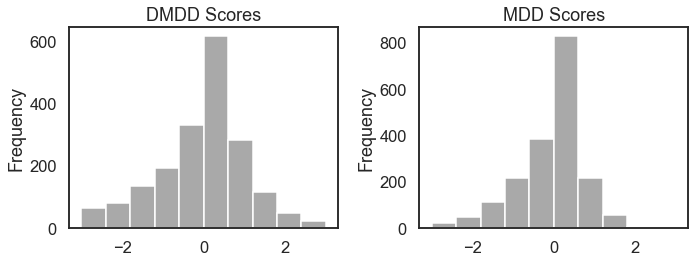

In [31]:
sns.set(context='talk', style='white')
import matplotlib.pyplot as plt

mri_sample[['DMDD_mean','MDD_mean']].plot(kind='hist', subplots=True, layout=(1,2), figsize = (10,4), 
                                          legend=False, title=['DMDD Scores', 'MDD Scores'], color=['darkgray','darkgray'])
plt.tight_layout()
plt.savefig('DMDD_MDD_means_ESWAN.png')

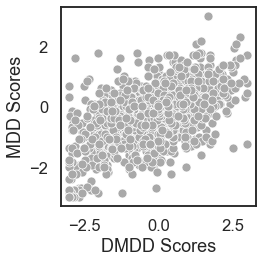

In [43]:
plt.figure(figsize=(4,4))
sns.scatterplot(x='DMDD_mean', y='MDD_mean', data=mri_sample, color='darkgray')
plt.xlabel('DMDD Scores')
plt.ylabel('MDD Scores')
plt.tight_layout()
plt.savefig('DMDD_MDD_corr_ESWAN.png')

In [33]:
from scipy.stats import spearmanr
r, p = spearmanr(mri_sample['DMDD_mean'], mri_sample['MDD_mean'], nan_policy='omit')
print(r)
print(p)

0.5305222543508663
5.549358068612389e-138


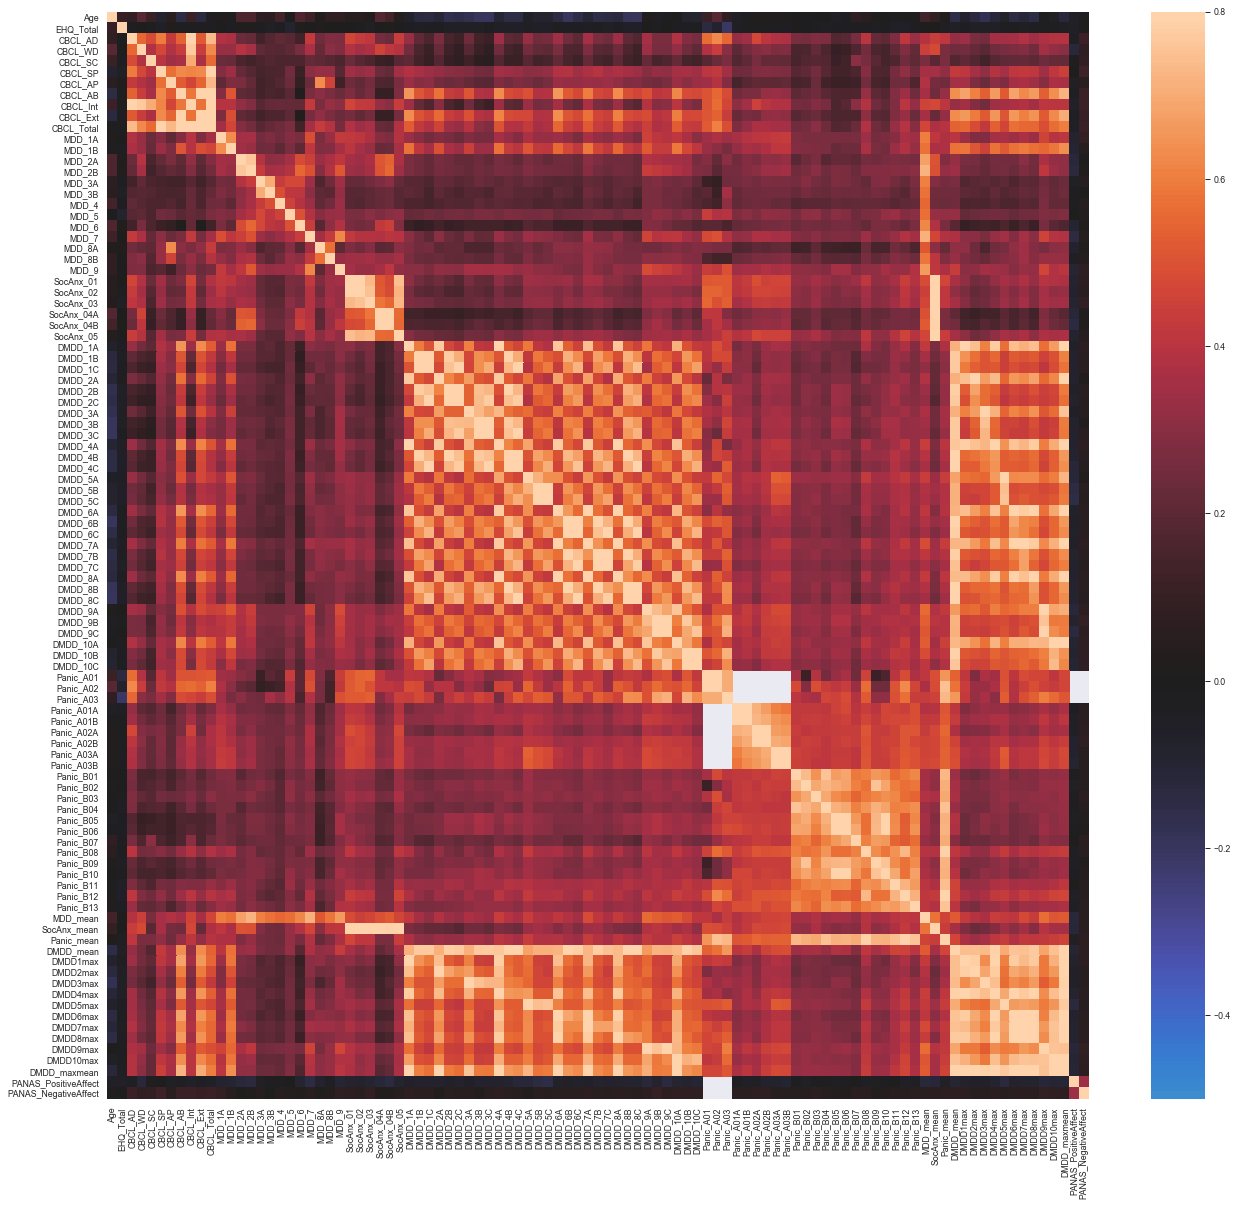

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(context='paper')

conn=mri_sample.iloc[:,3:].corr(method='spearman')

plt.figure(figsize=(22,20))
sns.heatmap(conn, vmax=0.8, vmin=-0.5, center=0)
plt.show()

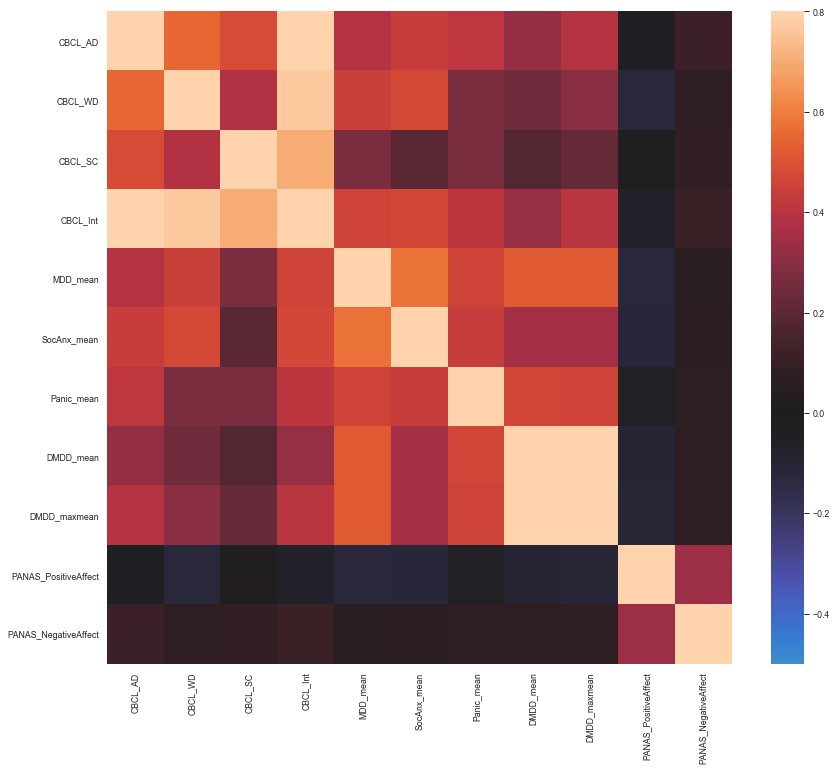

In [9]:
conn = mri_sample[['CBCL_AD','CBCL_WD','CBCL_SC','CBCL_Int','MDD_mean','SocAnx_mean',
                   'Panic_mean','DMDD_mean','DMDD_maxmean','PANAS_PositiveAffect','PANAS_NegativeAffect']].corr(method='spearman')
plt.figure(figsize=(14,12))
sns.heatmap(conn, vmax=0.8, vmin=-0.5, center=0)
plt.show()

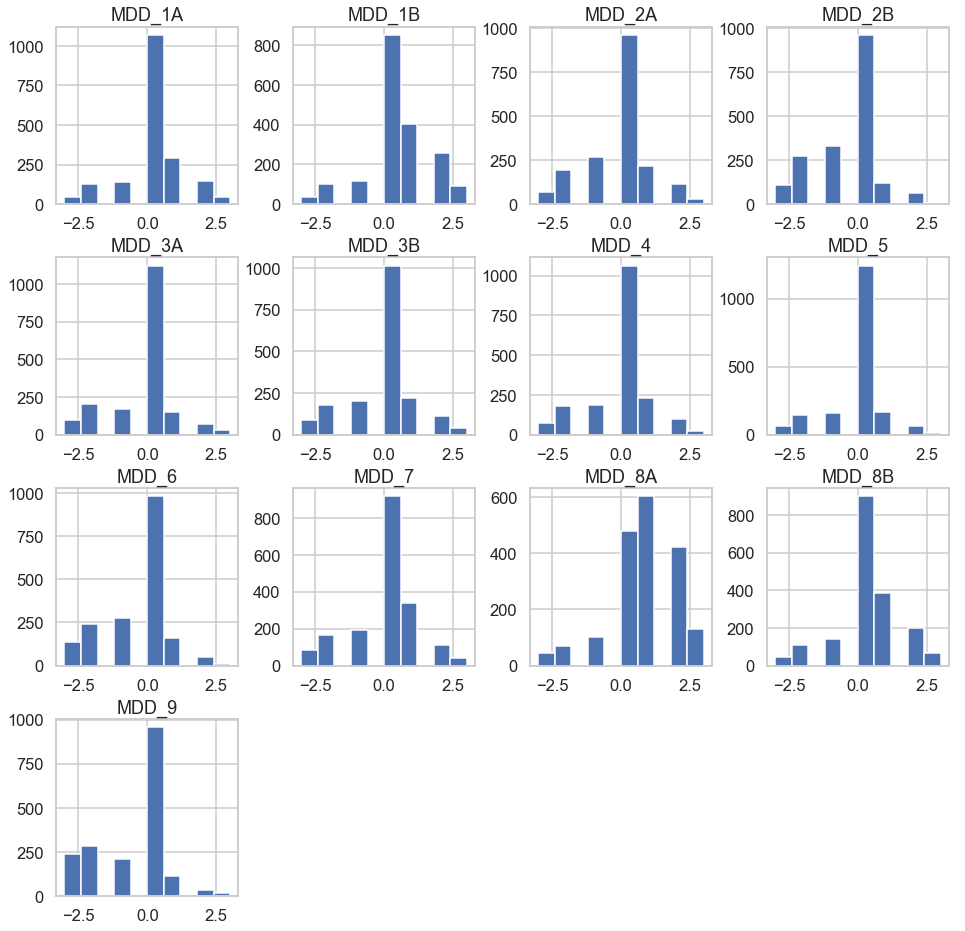

In [12]:
mri_sample[['MDD_1A','MDD_1B','MDD_2A','MDD_2B','MDD_3A','MDD_3B','MDD_4',
            'MDD_5','MDD_6','MDD_7','MDD_8A','MDD_8B','MDD_9']].hist(figsize=(16,16))
plt.savefig('ESWAN_MDD_items.svg')

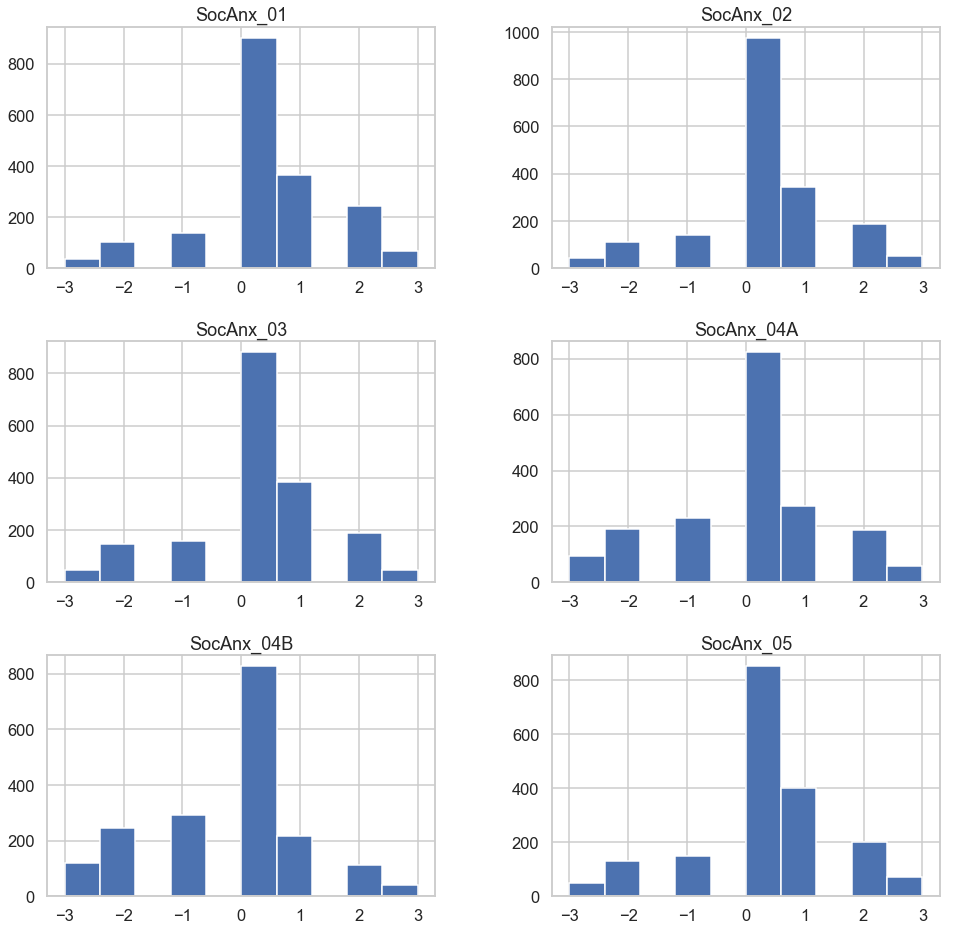

In [14]:
mri_sample[['SocAnx_01','SocAnx_02','SocAnx_03','SocAnx_04A','SocAnx_04B','SocAnx_05']].hist(figsize=(16,16))
plt.savefig('ESWAN_SocAnx_items.svg')

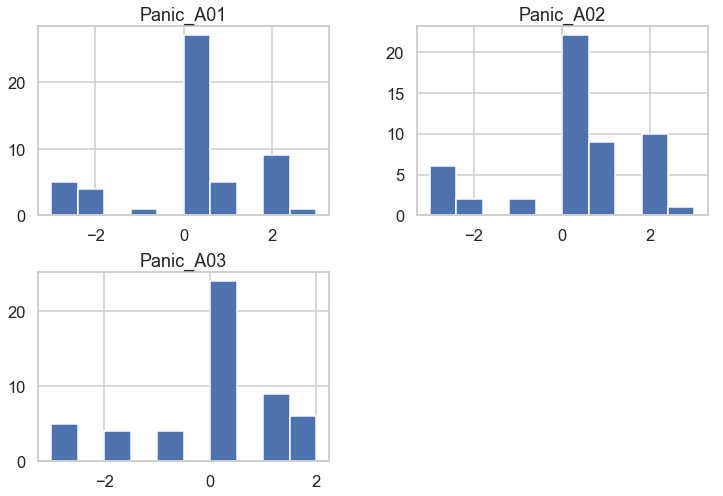

In [21]:
mri_sample[['Panic_A01','Panic_A02','Panic_A03']].hist(figsize=(12,8))
plt.savefig('ESWAN_panic_items.svg')

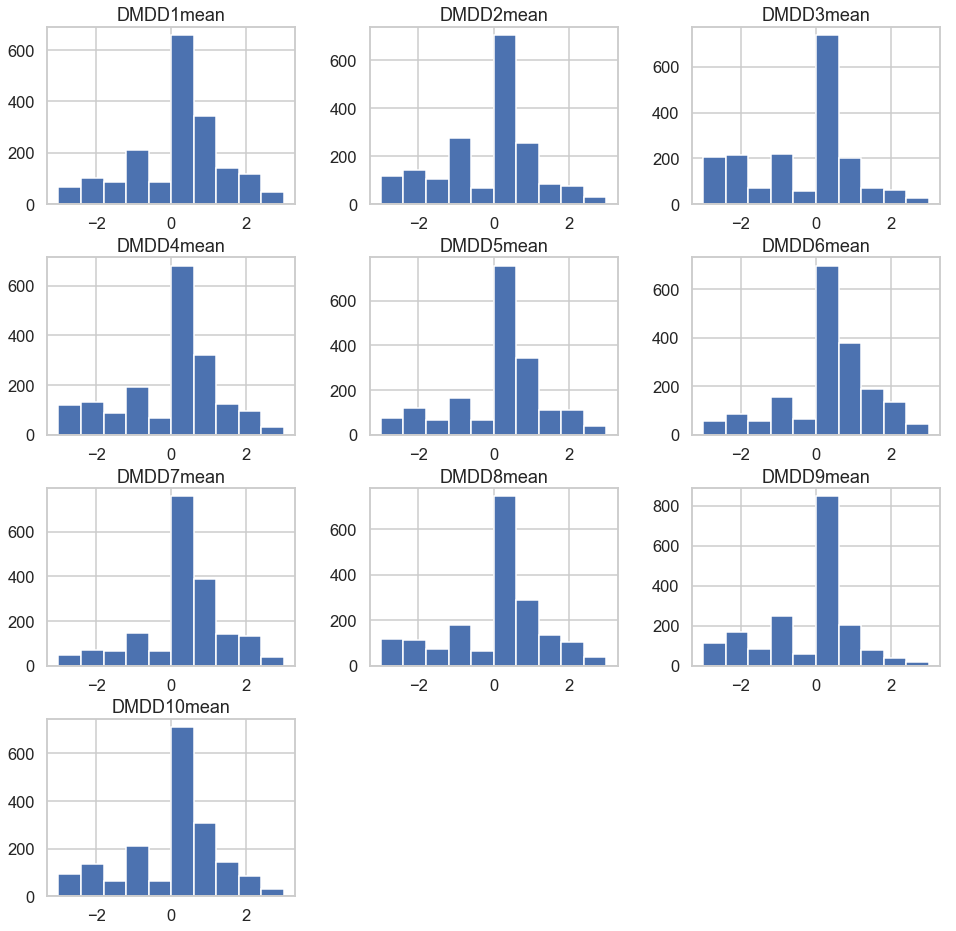

In [22]:
mri_sample[['DMDD1mean','DMDD2mean','DMDD3mean','DMDD4mean',
            'DMDD5mean','DMDD6mean','DMDD7mean','DMDD8mean','DMDD9mean','DMDD10mean']].hist(figsize=(16,16))
plt.savefig('ESWAN_DMDD_items.svg')

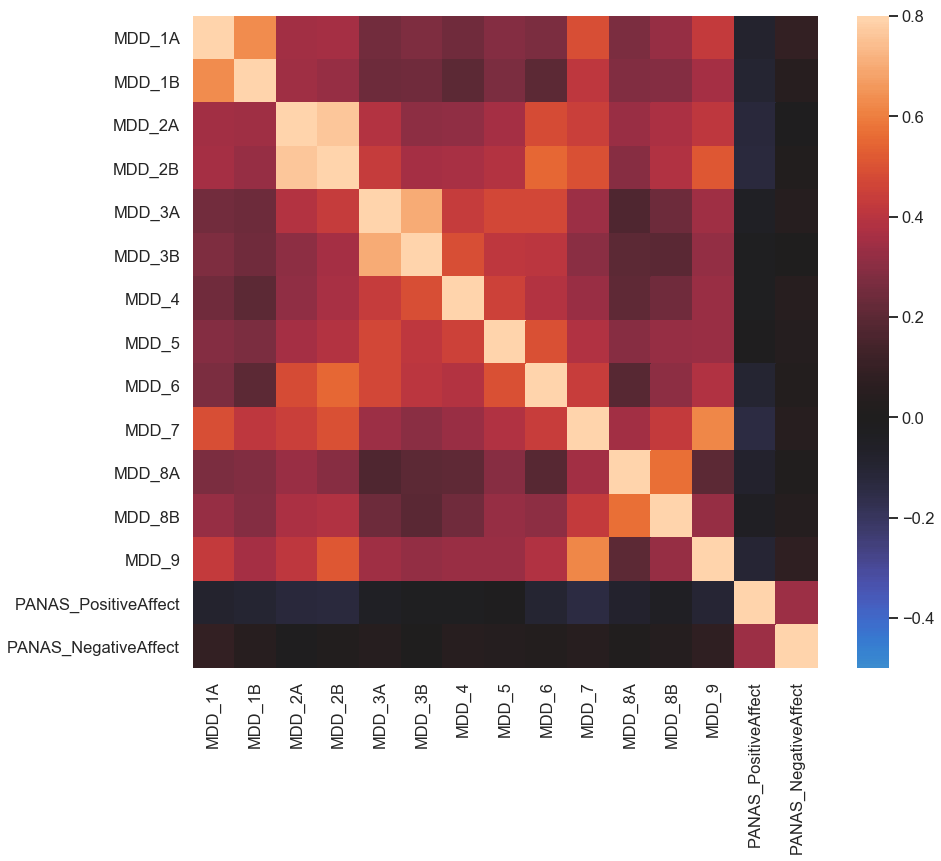

In [38]:
conn = mri_sample[['MDD_1A','MDD_1B','MDD_2A','MDD_2B','MDD_3A','MDD_3B','MDD_4','MDD_5','MDD_6',
                           'MDD_7','MDD_8A','MDD_8B','MDD_9','PANAS_PositiveAffect','PANAS_NegativeAffect']].corr(method='spearman')
plt.figure(figsize=(14,12))
sns.heatmap(conn, vmax=0.8, vmin=-0.5, center=0)
plt.show()

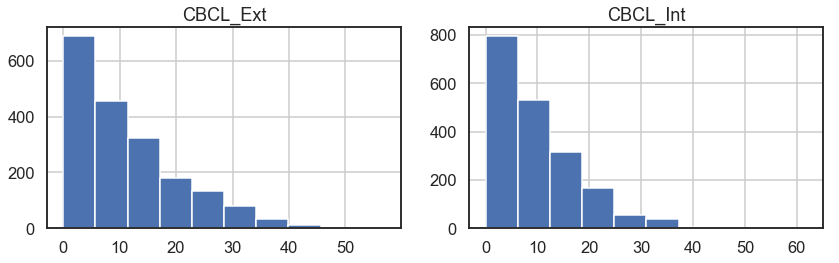

In [8]:
sns.set(context='talk',style='white')
mri_sample[['CBCL_Ext','CBCL_Int']].hist(figsize=(12,4))
plt.tight_layout()
plt.savefig('cbcl_hist.svg')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fce86165da0>,
      dtype=object)

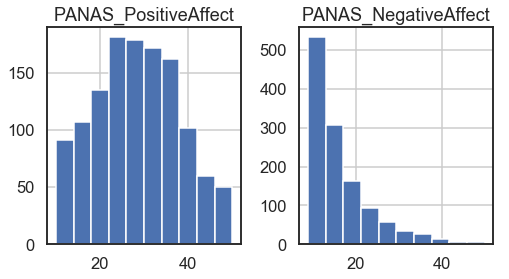

In [143]:
mri_sample[['PANAS_PositiveAffect','PANAS_NegativeAffect']].hist(figsize=(8,4))

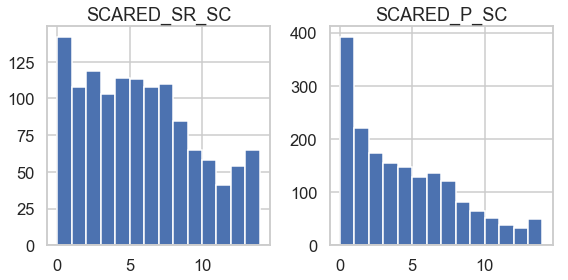

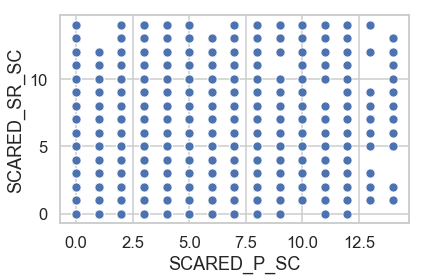

In [36]:
mri_sample[['SCARED_SR_SC','SCARED_P_SC']].hist(figsize=(8,4),bins=14)
plt.tight_layout()
plt.savefig('SCARED_hist.svg')
plt.show()
plt.close()
sns.scatterplot(x='SCARED_P_SC', y='SCARED_SR_SC',data=mri_sample)
plt.tight_layout()
plt.savefig('SCARED_scatter.svg')

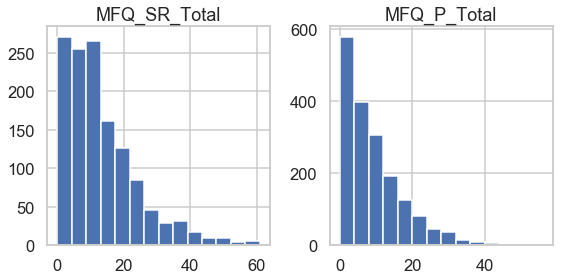

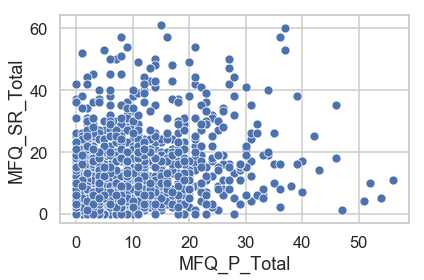

In [17]:
mri_sample[['MFQ_SR_Total','MFQ_P_Total']].hist(figsize=(8,4),bins=14)
plt.tight_layout()
plt.savefig('MFQ_hist.svg')
plt.show()
plt.close()
sns.scatterplot(x='MFQ_P_Total', y='MFQ_SR_Total',data=mri_sample)
plt.tight_layout()
plt.savefig('MFQ_scatter.svg')

In [ ]:
mri_sample[['MFQ_SR_Total','MFQ_P_Total']].hist(figsize=(8,4),bins=14)
plt.tight_layout()
plt.savefig('MFQ_hist.svg')
plt.show()
plt.close()
sns.scatterplot(x='MFQ_P_Total', y='MFQ_SR_Total',data=mri_sample)
plt.tight_layout()
plt.savefig('MFQ_scatter.svg')

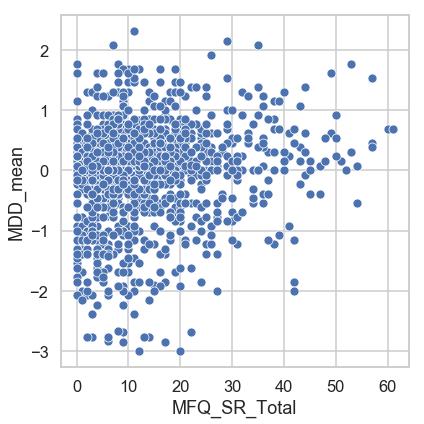

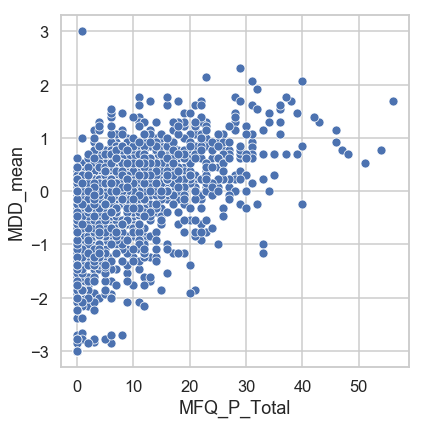

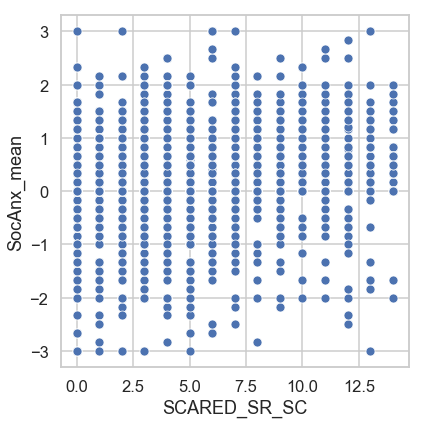

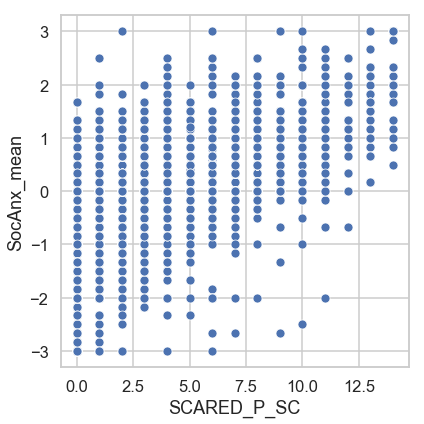

In [34]:
plt.figure(figsize=(6,6))
sns.scatterplot(x='MFQ_SR_Total',y='MDD_mean',data=mri_sample)
plt.tight_layout()
plt.savefig('MFQSR_ESWAN-MDD.svg')
plt.show()
plt.figure(figsize=(6,6))
sns.scatterplot(x='MFQ_P_Total',y='MDD_mean',data=mri_sample)
plt.tight_layout()
plt.savefig('MFQP_ESWAN-MDD.svg')
plt.show()
plt.close()
plt.figure(figsize=(6,6))
sns.scatterplot(x='SCARED_SR_SC',y='SocAnx_mean',data=mri_sample)
plt.tight_layout()
plt.savefig('SCAREDSR_ESWAN-socAnx.svg')
plt.show()
plt.close()
plt.figure(figsize=(6,6))
sns.scatterplot(x='SCARED_P_SC',y='SocAnx_mean',data=mri_sample)
plt.tight_layout()
plt.savefig('SCAREDP_ESWAN-SocAnx.svg')

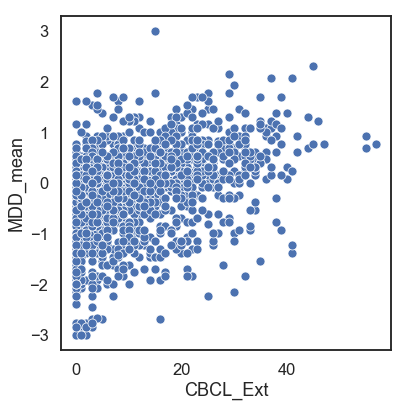

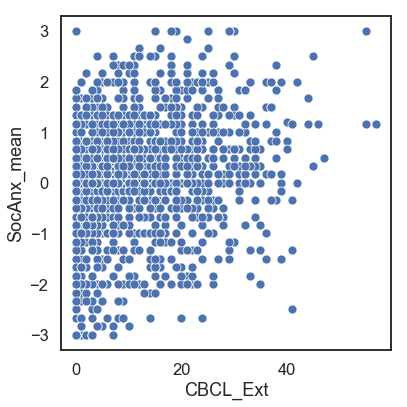

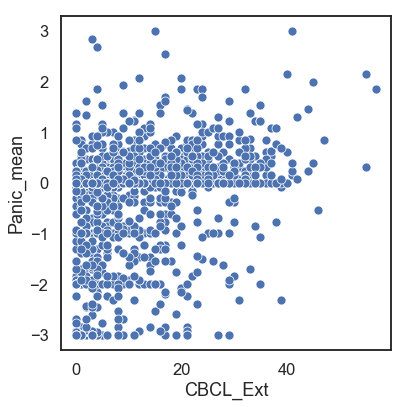

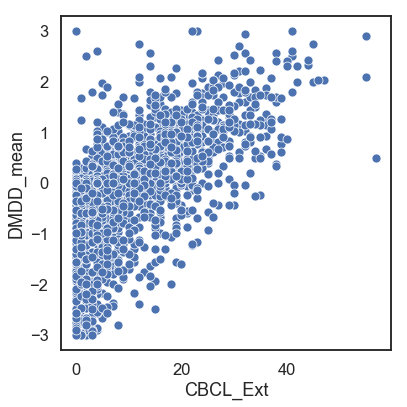

In [57]:
clinvars = ['MDD_mean','SocAnx_mean','Panic_mean','DMDD_mean']
for v in clinvars:
    plt.figure(figsize=(6,6))
    sns.scatterplot(x='CBCL_Ext',y=v,data=mri_sample)
    plt.tight_layout()
    plt.savefig('CBCLext_{0}.png'.format(v))
    plt.show()
    plt.close()

In [40]:
from scipy.stats import spearmanr
for v in ['MDD_mean','SocAnx_mean','MFQ_SR_Total','MFQ_P_Total','SCARED_SR_SC','SCARED_P_SC']:
    r, p = spearmanr(mri_sample['Age'],mri_sample[v],nan_policy='omit')
    print('{2}: r={0}, p={1}'.format(round(r,2),round(p,5),v))

MDD_mean: r=0.13, p=0.0
SocAnx_mean: r=0.09, p=7e-05
MFQ_SR_Total: r=-0.16, p=0.0
MFQ_P_Total: r=0.09, p=0.00029
SCARED_SR_SC: r=-0.11, p=0.00014
SCARED_P_SC: r=0.09, p=0.00014


In [42]:
r, p = spearmanr(mri_sample['MDD_mean'],mri_sample['MFQ_SR_Total'],nan_policy='omit')
print('r={0}, p={1}'.format(round(r,2),round(p,5)))
r, p = spearmanr(mri_sample['MDD_mean'],mri_sample['MFQ_P_Total'],nan_policy='omit')
print('r={0}, p={1}'.format(round(r,2),round(p,5)))
r, p = spearmanr(mri_sample['SocAnx_mean'],mri_sample['SCARED_SR_SC'],nan_policy='omit')
print('r={0}, p={1}'.format(round(r,2),round(p,5)))
r, p = spearmanr(mri_sample['SocAnx_mean'],mri_sample['SCARED_P_SC'],nan_policy='omit')
print('r={0}, p={1}'.format(round(r,2),round(p,5)))

r=0.15, p=0.0
r=0.44, p=0.0
r=0.17, p=0.0
r=0.53, p=0.0
